# Comments Training

Sentiment Analysis Training

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
from scipy import stats

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

model.eval()

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

    return preds.item()

In [ ]:
movie_data = pd.read_csv('movie_data_train.csv')

sentiment_metrics = []

for _, movie_row in tqdm(movie_data.iterrows(), desc="Processing movies", total=len(movie_data)):
    movie_id = movie_row['id']
    revenue = movie_row['revenue']

    try:
        with open(f'comments_dataset/{movie_id}.json', 'r') as f:
            comments_data = json.load(f)
        
        sentiments = []
        for item in tqdm(comments_data.get('items', []), desc=f"Movie {movie_id}", leave=False):
            comment_text = item['snippet']['topLevelComment']['snippet']['textOriginal']
            sentiment = predict_sentiment(comment_text)
            sentiments.append(sentiment)
        
        if not sentiments:
            continue
            
        sentiments_array = np.array(sentiments)
        total_comments = len(sentiments)
        
        avg_sentiment = np.mean(sentiments_array)
        median_sentiment = np.median(sentiments_array)
        std_sentiment = np.std(sentiments_array)
        max_sentiment = np.max(sentiments_array)
        min_sentiment = np.min(sentiments_array)
        
        positive_scores = np.sum(sentiments_array >= 4) / total_comments * 100
        negative_scores = np.sum(sentiments_array <= 2) / total_comments * 100
        
        skew = stats.skew(sentiments_array)
        
        engagement_level = total_comments / 100
        
        sentiment_metrics.append({
            'movie_id': movie_id,
            'avg_sentiment': avg_sentiment,
            'median_sentiment': median_sentiment,
            'std_sentiment': std_sentiment,
            'max_sentiment': max_sentiment,
            'min_sentiment': min_sentiment,
            'positive_percentage': positive_scores,
            'negative_percentage': negative_scores,
            'sentiment_skew': skew,
            'engagement_level': engagement_level,
            'revenue': revenue
        })
        
    except FileNotFoundError:
        print(f"No comments found for movie {movie_id}")

sentiment_df = pd.DataFrame(sentiment_metrics)

sentiment_df.to_csv('movie_sentiment_train.csv', index=False)

In [ ]:
movie_data = pd.read_csv('movie_data_test.csv')

sentiment_metrics = []

for _, movie_row in tqdm(movie_data.iterrows(), desc="Processing movies", total=len(movie_data)):
    movie_id = movie_row['id']
    revenue = movie_row['revenue']
    
    try:
        with open(f'comments_dataset/{movie_id}.json', 'r') as f:
            comments_data = json.load(f)
        
        sentiments = []
        for item in tqdm(comments_data.get('items', []), desc=f"Movie {movie_id}", leave=False):
            comment_text = item['snippet']['topLevelComment']['snippet']['textOriginal']
            sentiment = predict_sentiment(comment_text)
            sentiments.append(sentiment)
        
        if not sentiments:
            continue
            
        sentiments_array = np.array(sentiments)
        total_comments = len(sentiments)
        
        avg_sentiment = np.mean(sentiments_array)
        median_sentiment = np.median(sentiments_array)
        std_sentiment = np.std(sentiments_array)
        max_sentiment = np.max(sentiments_array)
        min_sentiment = np.min(sentiments_array)
        
        positive_scores = np.sum(sentiments_array >= 4) / total_comments * 100
        negative_scores = np.sum(sentiments_array <= 2) / total_comments * 100
        
        skew = stats.skew(sentiments_array)
        
        engagement_level = total_comments / 100
        
        sentiment_metrics.append({
            'movie_id': movie_id,
            'avg_sentiment': avg_sentiment,
            'median_sentiment': median_sentiment,
            'std_sentiment': std_sentiment,
            'max_sentiment': max_sentiment,
            'min_sentiment': min_sentiment,
            'positive_percentage': positive_scores,
            'negative_percentage': negative_scores,
            'sentiment_skew': skew,
            'engagement_level': engagement_level,
            'revenue': revenue
        })
        
    except FileNotFoundError:
        print(f"No comments found for movie {movie_id}")

sentiment_df = pd.DataFrame(sentiment_metrics)

sentiment_df.to_csv('movie_sentiment_test.csv', index=False)


Training with num_leaves=2 and num_estimators=500
num_leaves=2, num_estimators=500 - Validation RMSE: 205880318.84, R²: 0.0100

Training with num_leaves=2 and num_estimators=1000
num_leaves=2, num_estimators=1000 - Validation RMSE: 206161784.12, R²: 0.0073

Training with num_leaves=2 and num_estimators=1500
num_leaves=2, num_estimators=1500 - Validation RMSE: 206450824.99, R²: 0.0045

Training with num_leaves=2 and num_estimators=2000
num_leaves=2, num_estimators=2000 - Validation RMSE: 206724070.00, R²: 0.0018

Training with num_leaves=2 and num_estimators=2500
num_leaves=2, num_estimators=2500 - Validation RMSE: 206956767.73, R²: -0.0004

Training with num_leaves=3 and num_estimators=500
num_leaves=3, num_estimators=500 - Validation RMSE: 208436075.07, R²: -0.0148

Training with num_leaves=3 and num_estimators=1000
num_leaves=3, num_estimators=1000 - Validation RMSE: 209876568.21, R²: -0.0288

Training with num_leaves=3 and num_estimators=1500
num_leaves=3, num_estimators=1500 - Val

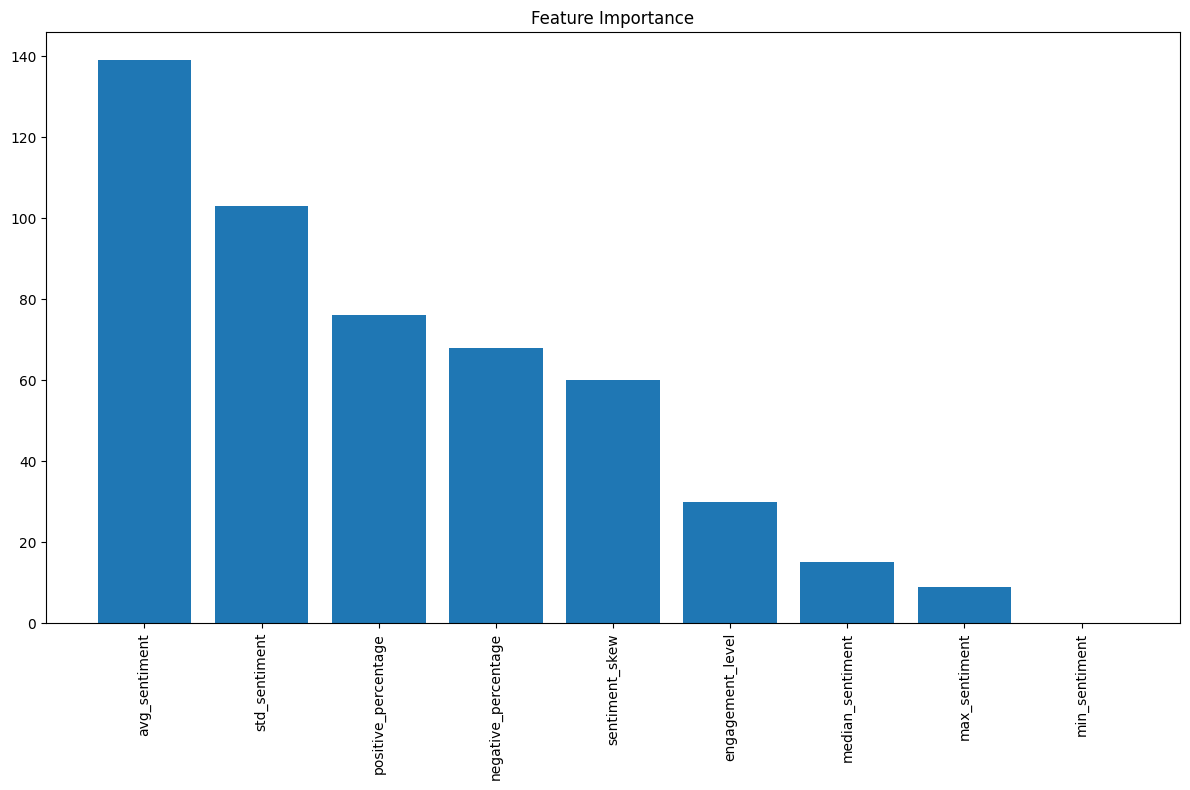


Top 10 most important features:
avg_sentiment: 139.0000
std_sentiment: 103.0000
positive_percentage: 76.0000
negative_percentage: 68.0000
sentiment_skew: 60.0000
engagement_level: 30.0000
median_sentiment: 15.0000
max_sentiment: 9.0000
min_sentiment: 0.0000


In [17]:
train_data = pd.read_csv('movie_sentiment_train.csv')

X_train = train_data.drop('revenue', axis=1)
X_train = X_train.drop(columns=['movie_id'])
y_train = train_data['revenue']

X_train = X_train.fillna(0)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Base parameters for all models
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'verbose': -1
}

# Define the different values for num_leaves to try
num_leaves_options = [2, 3, 4, 5, 6]
num_estimators_options = [500, 1000, 1500, 2000, 2500]

# Dictionary to store results
results = {}

# Manually try each parameter combination
for num_leaves in num_leaves_options:
    for num_estimators in num_estimators_options:
        print(f"\nTraining with num_leaves={num_leaves} and num_estimators={num_estimators}")
        
        # Create model with current parameters
        params = {**base_params, 'num_leaves': num_leaves, 'n_estimators': num_estimators}
        model = lgb.LGBMRegressor(**params)
        
        # Train the model
        model.fit(
            X_train_split, 
            y_train_split,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse'
        )
        
        # Make predictions on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        # Store results
        key = (num_leaves, num_estimators)
        results[key] = {'rmse': rmse, 'r2': r2}
        
        print(f"num_leaves={num_leaves}, num_estimators={num_estimators} - Validation RMSE: {rmse:.2f}, R²: {r2:.4f}")

# Find the best parameters based on RMSE
best_params = min(results.keys(), key=lambda k: results[k]['rmse'])
best_num_leaves, best_num_estimators = best_params
print(f"\nBest parameters: num_leaves={best_num_leaves}, num_estimators={best_num_estimators}")
print(f"Best validation RMSE: {results[best_params]['rmse']:.2f}")
print(f"Best validation R²: {results[best_params]['r2']:.4f}")

# Train final model on full training data with best parameters
final_params = {**base_params, 'num_leaves': best_num_leaves, 'n_estimators': best_num_estimators}
full_model = lgb.LGBMRegressor(**final_params)
full_model.fit(X_train, y_train)

# Evaluate on test data
test_data = pd.read_csv('movie_sentiment_test.csv')
X_test = test_data.drop('revenue', axis=1)
X_test = X_test.drop(columns=['movie_id'])
y_test = test_data['revenue']
X_test = X_test.fillna(0)

test_predictions = full_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"\nTest RMSE: {test_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = full_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(feature_importance)[::-1]

# Create a bar chart of feature importances
plt.title('Feature Importance')
plt.bar(range(len(indices)), feature_importance[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 most important features:")
for i in range(min(10, len(feature_names))):
    print(f"{feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")



In [26]:
# Retrain the model using only the top 6 features
print("\n--- Retraining model with top 5 features ---")

# Extract the top 6 feature names
top_features = [
    'avg_sentiment',
    'std_sentiment',
    'positive_percentage',
    'sentiment_skew'
]

# Create new training dataset with only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Define parameter grid for top features model
print("Performing grid search for top 6 features model...")
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'verbose': -1
}

# Define the different values for num_leaves to try
num_leaves_options = [2, 3, 4, 5, 6]
num_estimators_options = [100, 200, 300, 400, 500]

# Dictionary to store results
results = {}

# Manually try each parameter combination
for num_leaves in num_leaves_options:
    for num_estimators in num_estimators_options:
        print(f"\nTraining with num_leaves={num_leaves} and num_estimators={num_estimators}")
        
        # Create model with current parameters
        params = {**base_params, 'num_leaves': num_leaves, 'n_estimators': num_estimators}
        model = lgb.LGBMRegressor(**params)
        
        # Train the model
        model.fit(
            X_train_split, 
            y_train_split,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse'
        )
        
        # Make predictions on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        # Store results
        key = (num_leaves, num_estimators)
        results[key] = {'rmse': rmse, 'r2': r2}
        
        print(f"num_leaves={num_leaves}, num_estimators={num_estimators} - Validation RMSE: {rmse:.2f}, R²: {r2:.4f}")

# Find the best parameters based on RMSE
best_params_top = min(results.keys(), key=lambda k: results[k]['rmse'])
best_num_leaves_top, best_num_estimators_top = best_params_top
print(f"\nBest parameters for top 6 features: num_leaves={best_num_leaves_top}, num_estimators={best_num_estimators_top}")
print(f"Best validation RMSE: {results[best_params_top]['rmse']:.2f}")
print(f"Best validation R²: {results[best_params_top]['r2']:.4f}")

# Train final model on full training data with best parameters
final_params_top = {**base_params, 'num_leaves': best_num_leaves_top, 'n_estimators': best_num_estimators_top}
top_model = lgb.LGBMRegressor(**final_params_top)
top_model.fit(X_train_top, y_train)

# Evaluate on test data
top_test_predictions = top_model.predict(X_test_top)
top_test_rmse = np.sqrt(mean_squared_error(y_test, top_test_predictions))
top_test_r2 = r2_score(y_test, top_test_predictions)

print(f"\nTop 6 features model - Test RMSE: {top_test_rmse:.2f}")
print(f"Top 6 features model - Test R²: {top_test_r2:.4f}")

# Compare with full model
print(f"\nPerformance comparison:")
print(f"Full model (all features) - Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")
print(f"Top 6 features model - Test RMSE: {top_test_rmse:.2f}, R²: {top_test_r2:.4f}")



--- Retraining model with top 5 features ---
Performing grid search for top 6 features model...

Training with num_leaves=2 and num_estimators=100
num_leaves=2, num_estimators=100 - Validation RMSE: 205778787.54, R²: 0.0109

Training with num_leaves=2 and num_estimators=200
num_leaves=2, num_estimators=200 - Validation RMSE: 205698325.75, R²: 0.0117

Training with num_leaves=2 and num_estimators=300
num_leaves=2, num_estimators=300 - Validation RMSE: 205737201.68, R²: 0.0113

Training with num_leaves=2 and num_estimators=400
num_leaves=2, num_estimators=400 - Validation RMSE: 205778031.42, R²: 0.0110

Training with num_leaves=2 and num_estimators=500
num_leaves=2, num_estimators=500 - Validation RMSE: 205880318.84, R²: 0.0100

Training with num_leaves=3 and num_estimators=100
num_leaves=3, num_estimators=100 - Validation RMSE: 205796888.79, R²: 0.0108

Training with num_leaves=3 and num_estimators=200
num_leaves=3, num_estimators=200 - Validation RMSE: 206573749.88, R²: 0.0033

Traini